In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pycountry_convert as pc
import os
import geoplot
import geopandas
import pycountry
from github import Github
from datetime import datetime
from functools import reduce

plt.rcParams["figure.figsize"] = (16, 10)

In [3]:
twitter_daily_reports_dir_name = "twitter_daily_data/"

# Twitter daily reports parsing

In [4]:
reports_files_names = os.listdir(twitter_daily_reports_dir_name)
twitter_reports = []
for report_file_name in reports_files_names:
    date = datetime.strptime(report_file_name[:-4], '%d-%m-%Y')
    dataframe = pd.read_csv(os.path.join(twitter_daily_reports_dir_name, report_file_name), index_col=0)    
    dataframe = dataframe.astype({'tweets': 'int64'}, copy=False)
    twitter_reports.append((date, dataframe))
twitter_reports_dfs = np.array(sorted(twitter_reports, key=(lambda report: report[0])))
twitter_reports_dfs.shape

(19, 2)

In [5]:
print(twitter_reports_dfs[:5, 0])
twitter_reports_dfs[1, 1].head()

[datetime.datetime(2020, 3, 7, 0, 0) datetime.datetime(2020, 3, 8, 0, 0)
 datetime.datetime(2020, 3, 9, 0, 0) datetime.datetime(2020, 3, 10, 0, 0)
 datetime.datetime(2020, 3, 11, 0, 0)]


,country,tweets
0,afghanistan,252
1,albania,185
2,algeria,357
3,american samoa,13
4,andorra,155


In [6]:
def twitter_df_to_dict(df):
    return df.set_index('country').T.to_dict('records')[0]
twitter_reports_dicts = np.array([(date, twitter_df_to_dict(df)) for date, df in twitter_reports_dfs])
twitter_reports_dicts.shape

(19, 2)

In [7]:
twitter_reports_dicts[1, 1]

{'afghanistan': 252,
 'albania': 185,
 'algeria': 357,
 'american samoa': 13,
 'andorra': 155,
 'angola': 191,
 'anguilla': 15,
 'antarctica': 392,
 'antigua and barbuda': 31,
 'argentina': 41839,
 'armenia': 123,
 'aruba': 105,
 'australia': 21177,
 'austria': 2330,
 'azerbaijan': 103,
 'bahamas': 305,
 'bahrain': 382,
 'bangladesh': 1171,
 'barbados': 191,
 'belarus': 80,
 'belgium': 6144,
 'belize': 68,
 'benin': 258,
 'bermuda': 184,
 'bhutan': 83,
 'bolivia, plurinational state of': 855,
 'bonaire, sint eustatius and saba': 0,
 'bosnia and herzegovina': 37,
 'botswana': 311,
 'bouvet island': 2,
 'brazil': 12254,
 'british indian ocean territory': 0,
 'brunei darussalam': 141,
 'bulgaria': 321,
 'burkina faso': 82,
 'burundi': 44,
 'cabo verde': 1,
 'cambodia': 188,
 'cameroon': 484,
 'canada': 29337,
 'cayman islands': 121,
 'central african republic': 2,
 'chad': 111,
 'chile': 8082,
 'china': 2844,
 'christmas island': 32,
 'cocos (keeling) islands': 0,
 'colombia': 16108,
 'co

# Plotting Twitter data for whole world

In [8]:
xd = twitter_reports_dfs[1, 1]
xd.sum()

country    afghanistanalbaniaalgeriaamerican samoaandorra...
tweets                                               1018668
dtype: object

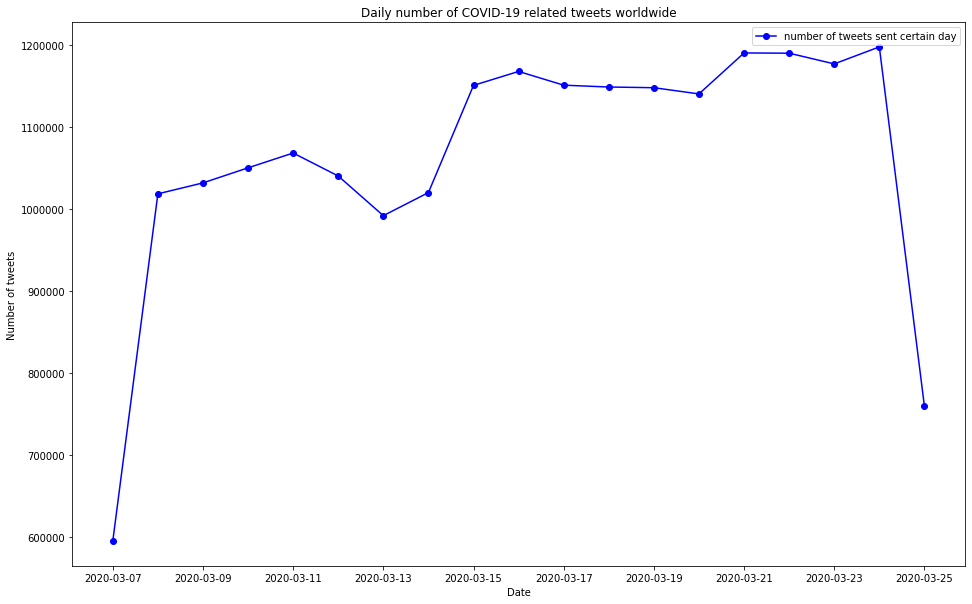

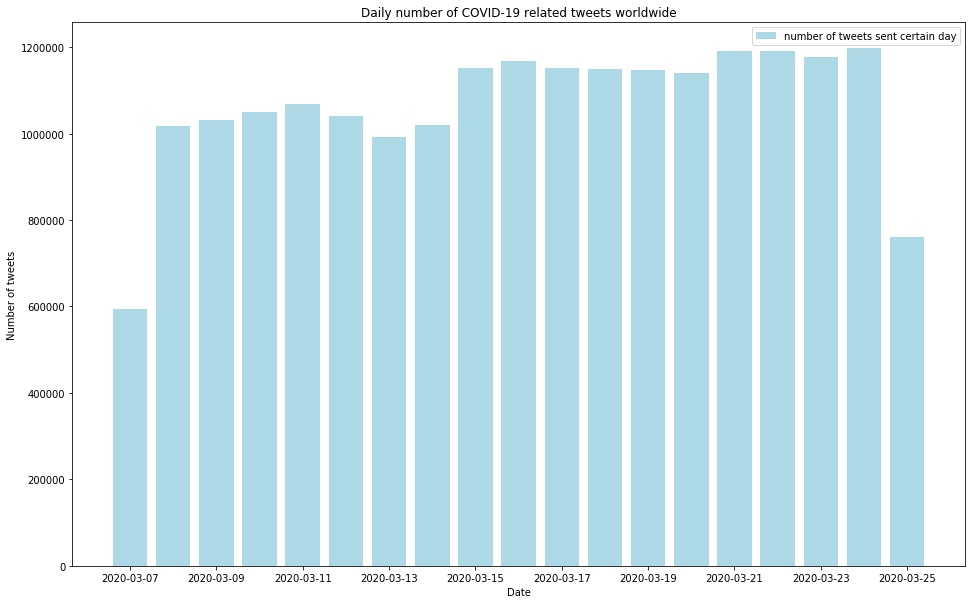

In [9]:
daily_world_tweets = [report.sum()['tweets'] for report in twitter_reports_dfs[:, 1]]

fig, ax = plt.subplots(1, 1)
ax.set_title('Daily number of COVID-19 related tweets worldwide')
ax.plot(twitter_reports_dfs[:, 0], daily_world_tweets, 'o-', c='blue', label='number of tweets sent certain day')
ax.legend()
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title('Daily number of COVID-19 related tweets worldwide')
ax.bar(twitter_reports_dfs[:, 0], daily_world_tweets, color='lightblue', label='number of tweets sent certain day')
ax.legend()
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.show()

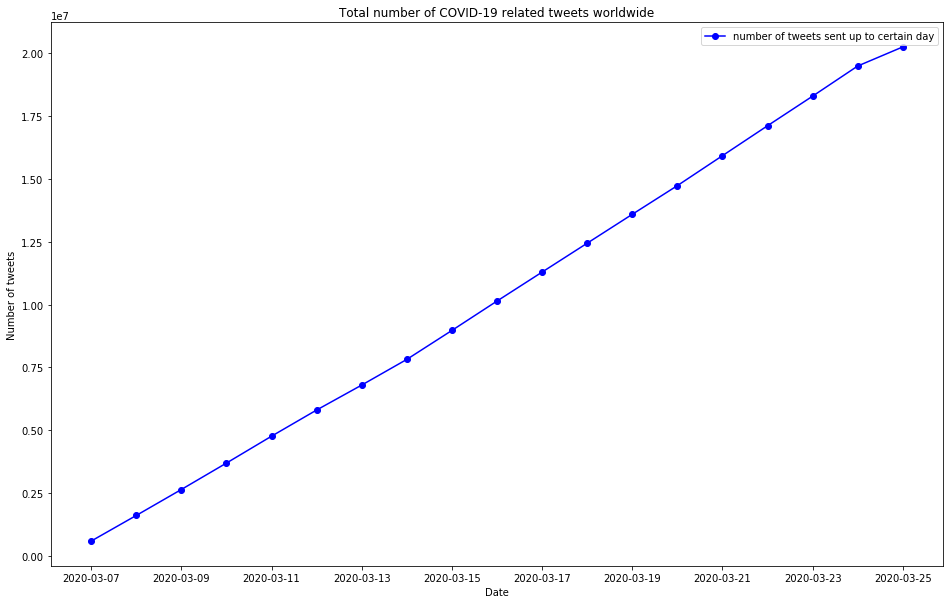

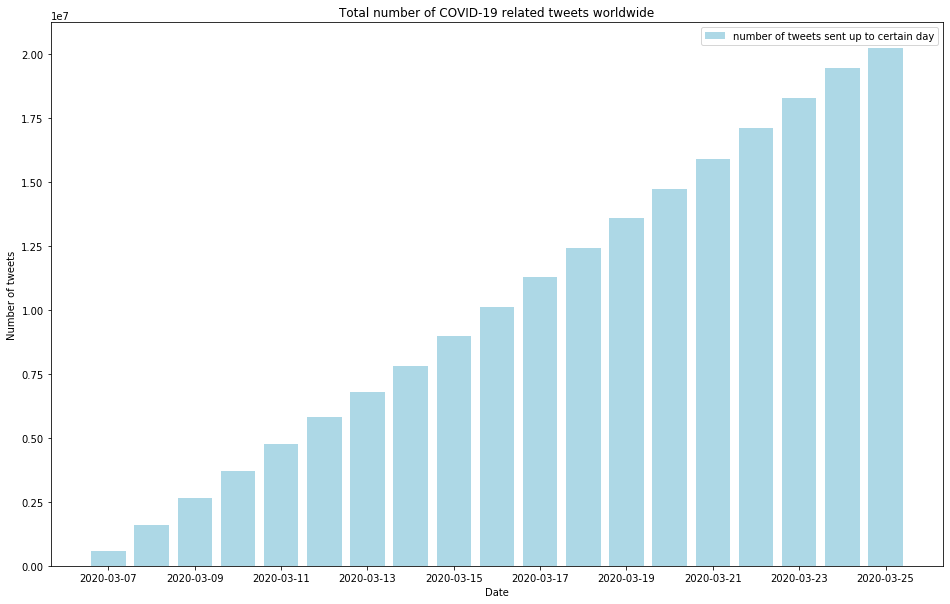

In [10]:
daily_cumulative_world_tweets = []
previous_tweets = 0
for report in twitter_reports_dfs[:, 1]:
    previous_tweets += report.sum()['tweets']
    daily_cumulative_world_tweets.append(previous_tweets)

fig, ax = plt.subplots(1, 1)
ax.set_title('Total number of COVID-19 related tweets worldwide')
ax.plot(twitter_reports_dfs[:, 0], daily_cumulative_world_tweets, 'o-', c='blue', label='number of tweets sent up to certain day')
ax.legend()
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.show()

fig, ax = plt.subplots(1, 1)
ax.set_title('Total number of COVID-19 related tweets worldwide')
ax.bar(twitter_reports_dfs[:, 0], daily_cumulative_world_tweets, color='lightblue', label='number of tweets sent up to certain day')
ax.legend()
plt.xlabel("Date")
plt.ylabel("Number of tweets")
plt.show()

# Plotting Twitter data for certain regions

In [11]:
def resolve_plot_title(countries_list, cumulative):
    if len(countries_list) > 1:
        formatted_list = reduce(lambda acc, val: acc + ', ' + val if acc != "" else val, countries_list, "")
        if cumulative:
            return 'Total number of tweets sent from countries: ' + formatted_list
        return 'Daily number of tweets sent from countries: ' + formatted_list
    if cumulative:
        return 'Total number of tweets sent from country ' + str(countries_list[0])
    return 'Daily number of tweets sent from country ' + str(countries_list[0])

def resolve_label(cumulative):
    if cumulative:
        return 'number of tweets sent up to certain day'
    else:
        return 'number of tweets sent certain day'

def plot_for_countries(countries_list, cumulative=False, plot_type='line'):
    tweets_counts = [0]
    for report in twitter_reports_dfs[:, 1]:
        tweets_count = report.set_index('country').reindex(countries_list, fill_value=0).sum()['tweets']
        tweets_counts.append(tweets_count)
        if cumulative:
            tweets_counts[-1] += tweets_counts[-2]
    tweets_counts = tweets_counts[1:]
        
    fig, ax = plt.subplots(1, 1)
    ax.set_title(resolve_plot_title(countries_list, cumulative))
     
    if plot_type == 'line':
        ax.plot(twitter_reports_dfs[:, 0], tweets_counts, 'o-', c='blue', label=resolve_label(cumulative))
    elif plot_type == 'bar':
        ax.bar(twitter_reports_dfs[:, 0], tweets_counts, color='lightblue', label=resolve_label(cumulative))
    else:
        raise Exception("Incorrect plot_type argument, possible options are 'line' and 'bar'")
    ax.legend()
    plt.xlabel("Date")
    plt.ylabel("Number of tweets")
    plt.show()

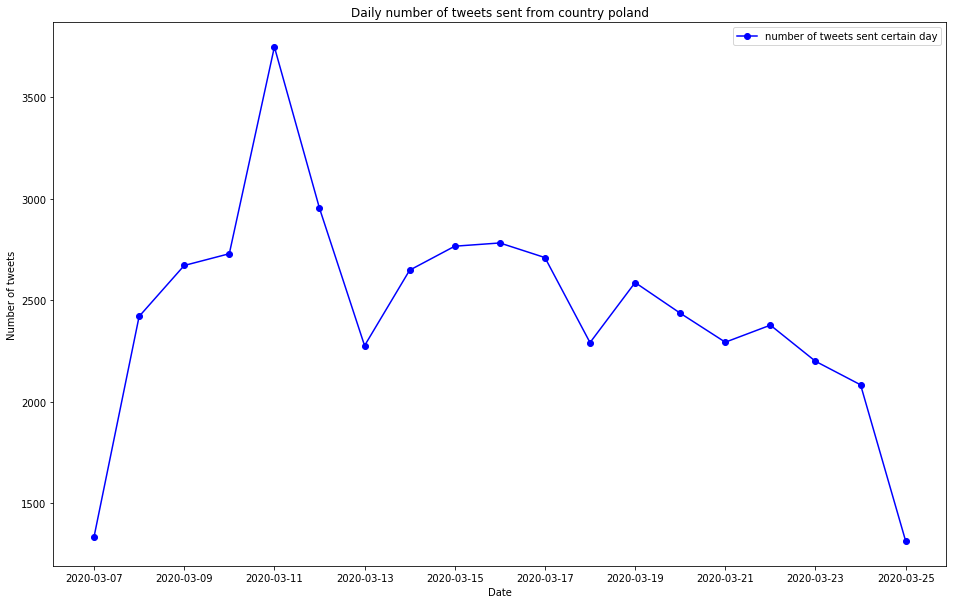

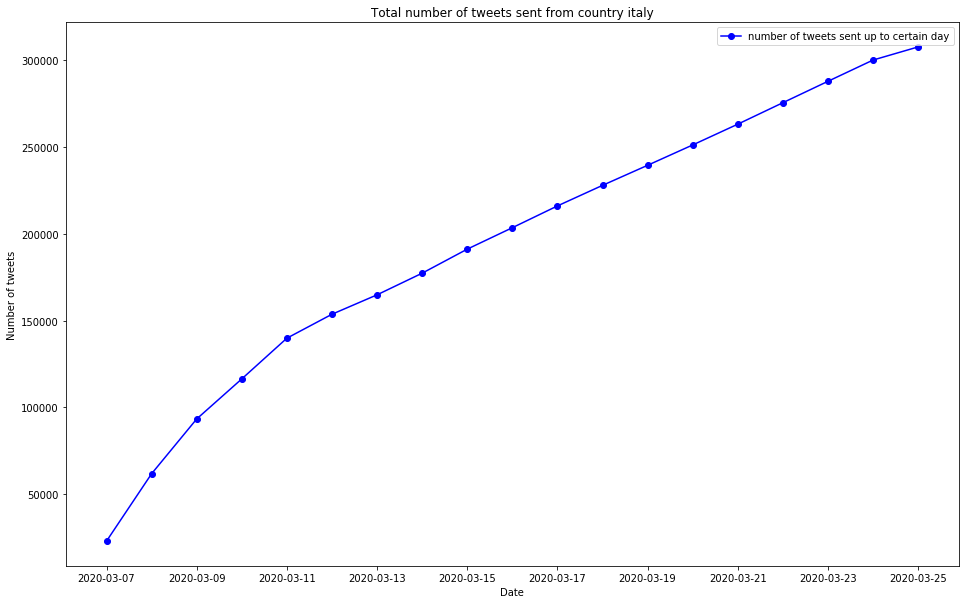

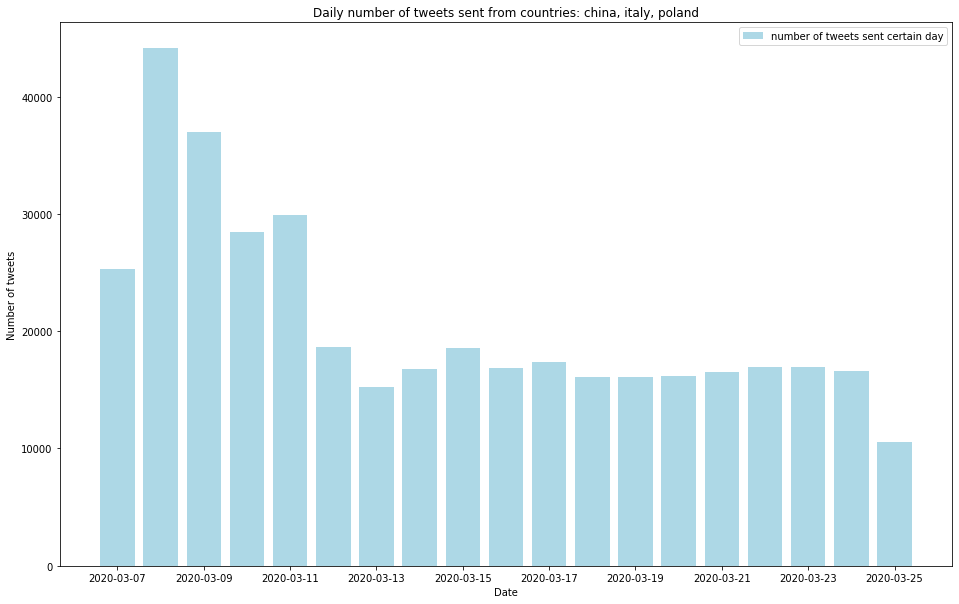

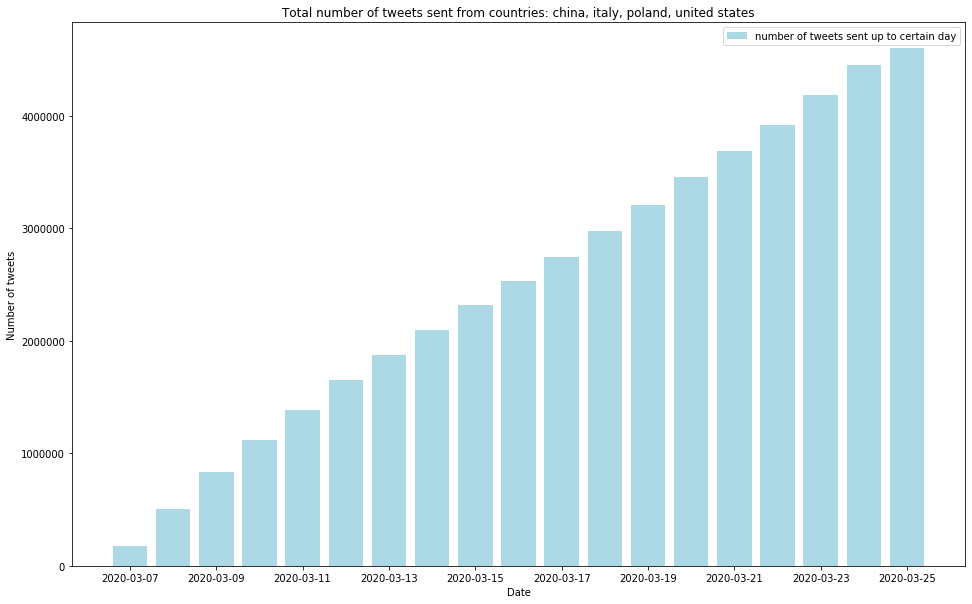

In [12]:
plot_for_countries(['poland'])
plot_for_countries(['italy'], cumulative=True)
plot_for_countries(['china', 'italy', 'poland'], plot_type="bar")
plot_for_countries(['china', 'italy', 'poland', 'united states'], plot_type="bar", cumulative=True)

# Plotting Twitter data on map 

### Getting geopandas world map dataframe

In [13]:
world_map_df = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_map_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing world map dataframe (unify countries names)

In [14]:
countries_proper_names = {
    'W. Sahara': 'Western Sahara',
    'Dem. Rep. Congo': 'Congo',
    'Dominican Rep.': 'Dominican Republic',
    'Falkland Is.': 'Falkland Islands (Malvinas)',
    'Fr. S. Antarctic Lands': 'Antarctica',
    'Central African Rep.': 'Central African Republic',
    'Eq. Guinea': 'Equatorial Guinea',
    'Laos': 'Lao People\'s Democratic Republic',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'South Korea': 'Korea, Republic of',
    'Solomon Is.': 'Solomon Islands',
    'N. Cyprus': 'Cyprus',
    'Somaliland': 'Somalia',
    'Bosnia and Herz.': 'Bosnia and Herzegovina',
    'S. Sudan': 'South Sudan',
}


world_map_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name.lower() for country in world_map_df['name']]
world_map_df['name'] = new_countries_names
world_map_df.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,"tanzania, united republic of",TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,western sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,united states,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Preparing Twitter data (summing numbers of tweets sent from each country)

In [15]:
total_tweets_counts = {country.name.lower(): 0 for country in pycountry.countries}   

for report_dict in twitter_reports_dicts[:, 1]:
    for country, tweets_count in report_dict.items():
        total_tweets_counts[country] += tweets_count
    
total_tweets_counts_df = pd.DataFrame(total_tweets_counts.items(), columns=['country', 'tweets'])
total_tweets_counts_df.head()

,country,tweets
0,aruba,1679
1,afghanistan,5851
2,angola,5529
3,anguilla,149
4,åland islands,282


### Merging world map dataframe with total tweets counts dataframe

In [16]:
world_map_with_total_tweets_counts = world_map_df.join(total_tweets_counts_df.set_index("country"), on="name")
world_map_with_total_tweets_counts.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,tweets
0,920938,Oceania,fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",5223
1,53950935,Africa,"tanzania, united republic of",TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",18804
2,603253,Africa,western sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",261
3,35623680,North America,canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",459058
4,326625791,North America,united states,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",4207329


### Plotting tweets counts on world map

In [17]:
def plot_map(column_name, dataframe, title):
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    ax.set_title(title, fontdict={'fontsize': '26'})
    dataframe.plot(column=column_name, cmap='Greys', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    plt.show()

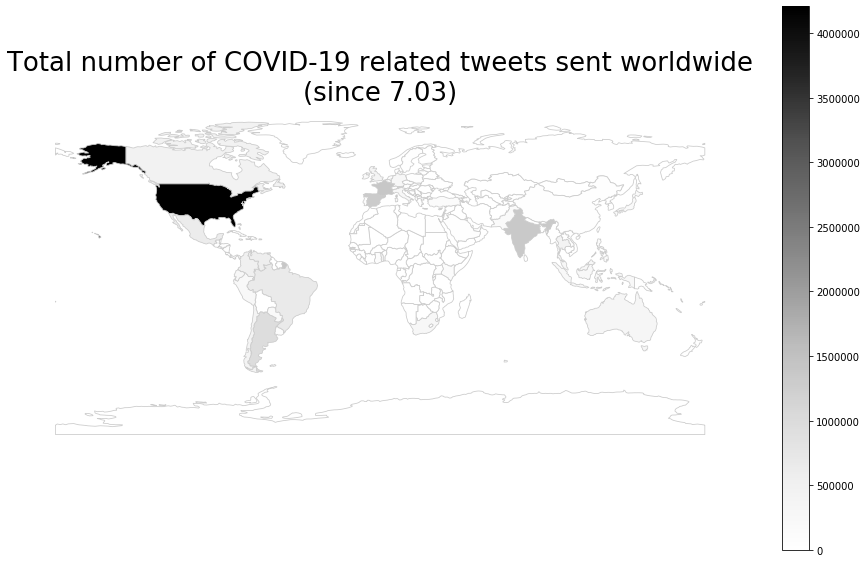

In [18]:
plot_map('tweets', world_map_with_total_tweets_counts, "Total number of COVID-19 related tweets sent worldwide\n(since 7.03)")   

### Ploting tweets counts on Europe map (excluding Russia and French Guiana for clarity)

In [19]:
def resolve_european_countries_indices():
    countries_map = pc.map_countries(cn_name_format="lower")
    countries_codes = [countries_map[country]['alpha_2'] for country in world_map_with_total_tweets_counts['name']]
    european_countries_indices = []
    for country_code in countries_codes:
        try:
            european_countries_indices.append(pc.country_alpha2_to_continent_code(country_code) == 'EU')
        except:
            european_countries_indices.append(False)
    return european_countries_indices

europe_map_with_total_tweets_counts = world_map_with_total_tweets_counts.loc[resolve_european_countries_indices(), :]
europe_map_with_total_tweets_counts = europe_map_with_total_tweets_counts.loc[europe_map_with_total_tweets_counts['name'] != 'russian federation', :]
france_geometry_values = europe_map_with_total_tweets_counts.loc[europe_map_with_total_tweets_counts['name'] == 'france', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_map_with_total_tweets_counts.loc[europe_map_with_total_tweets_counts['name'] == 'france', 'geometry'] = france_geometry_values

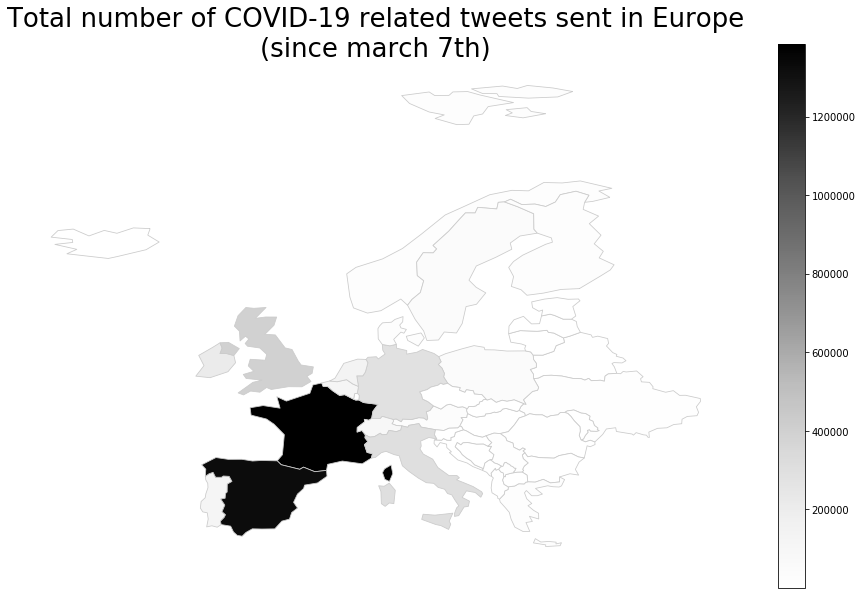

In [20]:
plot_map('tweets', europe_map_with_total_tweets_counts, "Total number of COVID-19 related tweets sent in Europe\n(since march 7th)")

### Getting population dataframe (data from https://worldpopulationreview.com/)

In [21]:
population_df = pd.read_csv("popultion.csv")[['name', 'pop2020']]
population_df["pop2020"] *= 1000
population_df = population_df.astype({'pop2020': 'int32'}, copy=False)
print('Population of Poland is:', population_df.loc[population_df['name'] == 'Poland', "pop2020"].values[0])
population_df.head()

Population of Poland is: 37846611


,name,pop2020
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


### Preparing population dataframe (unify countries names)

In [22]:
countries_proper_names = {
    'DR Congo': 'Congo',
    'South Korea': 'Korea, Republic of',
    'Ivory Coast': 'Côte d\'Ivoire',
    'North Korea': 'Korea, Democratic People\'s Republic of',
    'Laos': 'Lao People\'s Democratic Republic',
    'Swaziland': 'Eswatini',
    'Macau': 'Macao',
    'Cape Verde': 'Cabo Verde',
    'United States Virgin Islands': 'United States',
}


population_df.replace({'name': countries_proper_names}, inplace=True)
new_countries_names = [pycountry.countries.search_fuzzy(country)[0].name.lower() for country in population_df['name']]
population_df['name'] = new_countries_names
population_df = population_df.groupby('name', as_index=False).sum()
population_df.head()

,name,pop2020
0,afghanistan,38928346
1,albania,2877797
2,algeria,43851044
3,american samoa,55191
4,andorra,77265


### Merging population dataframe with tweets counts dataframe

In [23]:
tweets_counts_with_population = total_tweets_counts_df.join(population_df.set_index("name"), on='country')
# drop rows where pop2020 is NaN if there still are any
tweets_counts_with_population = tweets_counts_with_population.dropna(axis='index')
tweets_counts_with_population['tweets per person'] = tweets_counts_with_population['tweets'] / tweets_counts_with_population['pop2020']
tweets_counts_with_population.head()

,country,tweets,pop2020,tweets per person
0,aruba,1679,106766.0,0.015726
1,afghanistan,5851,38928346.0,0.000150
2,angola,5529,32866271.0,0.000168
3,anguilla,149,15003.0,0.009931
5,albania,2880,2877797.0,0.001001


### Merging world map dataframe with prepared dataframe containing tweets-per-person factor

In [24]:
world_map_with_tweets_per_person = world_map_df.join(tweets_counts_with_population.set_index("country"), on="name")
# Fill disease data for countries not included in report with 0
world_map_with_tweets_per_person.fillna(0, inplace=True)

### Displaying most and least tweeting countries

In [25]:
max_tweeting = tweets_counts_with_population.sort_values(by=['tweets per person'], ascending=False).iloc[:10, :]
print('Countries with maximal tweets-per-person factor:\n')
for i in range(10):
    print(max_tweeting.iloc[i, :]['country'], '-', max_tweeting.iloc[i, :]['tweets per person'])

Countries with maximal tweets-per-person factor:

dominica - 0.6570166421248577
holy see (vatican city state) - 0.3570536828963795
montserrat - 0.15124198717948717
monaco - 0.13704704143519697
niue - 0.13653136531365315
gibraltar - 0.07832952420527738
bermuda - 0.06377854137897813
maldives - 0.06264244908832584
andorra - 0.06042839578075455
palau - 0.05814082016137946


In [26]:
min_tweeting = tweets_counts_with_population.sort_values(by=['tweets per person']).iloc[:10, :]
print('Countries with minimal tweets-per-person factor:\n')
for i in range(10):
    print(min_tweeting.iloc[i, :]['country'], '-', min_tweeting.iloc[i, :]['tweets per person'])

Countries with minimal tweets-per-person factor:

south sudan - 0.0
palestine, state of - 0.0
korea, democratic people's republic of - 8.146223627958708e-07
papua new guinea - 4.135453308273232e-06
guinea-bissau - 7.6219473465714705e-06
equatorial guinea - 7.840425948958828e-06
somalia - 1.1136822980261648e-05
lao people's democratic republic - 1.1270610097367075e-05
moldova, republic of - 1.4873711038004067e-05
tajikistan - 1.8872583326387175e-05


### Plotting tweets-per-person factor on world map

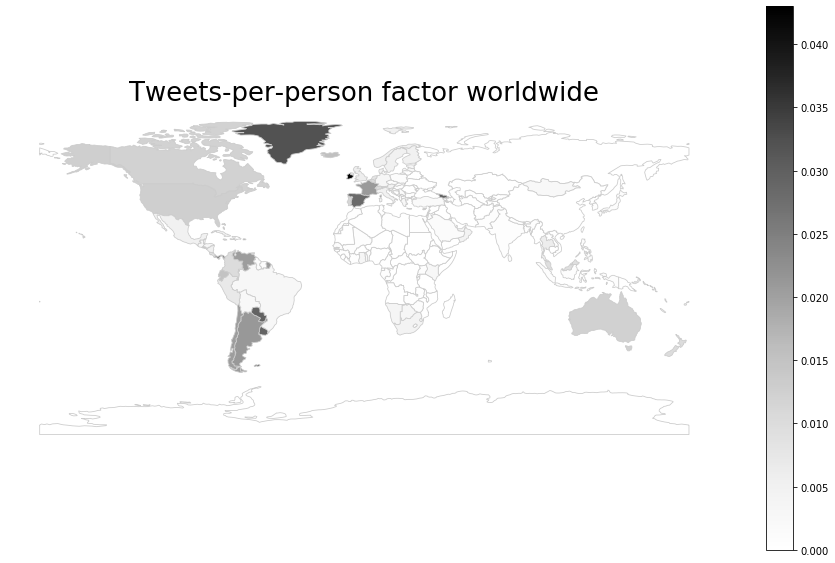

In [27]:
plot_map("tweets per person", world_map_with_tweets_per_person, "Tweets-per-person factor worldwide")

### Displaying most and least tweeting European countries 

In [28]:
def resolve_european_countries_indices():
    countries_map = pc.map_countries(cn_name_format="lower")
    countries_codes = [countries_map[country]['alpha_2'] for country in world_map_with_tweets_per_person['name']]
    european_countries_indices = []
    for country_code in countries_codes:
        try:
            european_countries_indices.append(pc.country_alpha2_to_continent_code(country_code) == 'EU')
        except:
            european_countries_indices.append(False)
    return european_countries_indices

europe_map_with_tweets_per_person = world_map_with_tweets_per_person.loc[resolve_european_countries_indices(), :].copy()
france_geometry_values = europe_map_with_tweets_per_person.loc[europe_map_with_tweets_per_person['name'] == 'france', 'geometry'].values
france_geometry_values[0] = france_geometry_values[0][1:]
europe_map_with_tweets_per_person.loc[europe_map_with_tweets_per_person['name'] == 'france', 'geometry'] = france_geometry_values

In [29]:
max_tweeting_europe = europe_map_with_tweets_per_person.sort_values(by=['tweets per person'], ascending=False).iloc[:10, :]
print('European countries with maximal tweets-per-person factor:\n')
for i in range(10):
    print(max_tweeting_europe.iloc[i, :]['name'], '-', max_tweeting_europe.iloc[i, :]['tweets per person'])

European countries with maximal tweets-per-person factor:

ireland - 0.04300631902638146
spain - 0.028381377407032067
france - 0.02099242643083896
iceland - 0.01550801042072658
luxembourg - 0.015093182188511417
portugal - 0.011267262800183864
switzerland - 0.010210035747372906
belgium - 0.01007901637525224
netherlands - 0.008174333970655133
united kingdom - 0.0058398482126162925


In [30]:
min_tweeting_europe = europe_map_with_tweets_per_person.sort_values(by=['tweets per person']).iloc[:10, :]
print('European countries with minimal tweets-per-person factor:\n')
for i in range(10):
    print(min_tweeting_europe.iloc[i, :]['name'], '-', min_tweeting_europe.iloc[i, :]['tweets per person'])

European countries with minimal tweets-per-person factor:

moldova, republic of - 1.4873711038004067e-05
russian federation - 9.877721685779745e-05
belarus - 0.00016477370918530353
north macedonia - 0.00016607683789700644
romania - 0.00024810669845980995
ukraine - 0.0002825963154050182
bosnia and herzegovina - 0.0003566182712304458
slovakia - 0.000513586788291247
bulgaria - 0.0005959606789720578
lithuania - 0.0006354946150096481


### Ploting tweets-per-person factor on Europe map (excluding Russia and French Guiana for clarity)

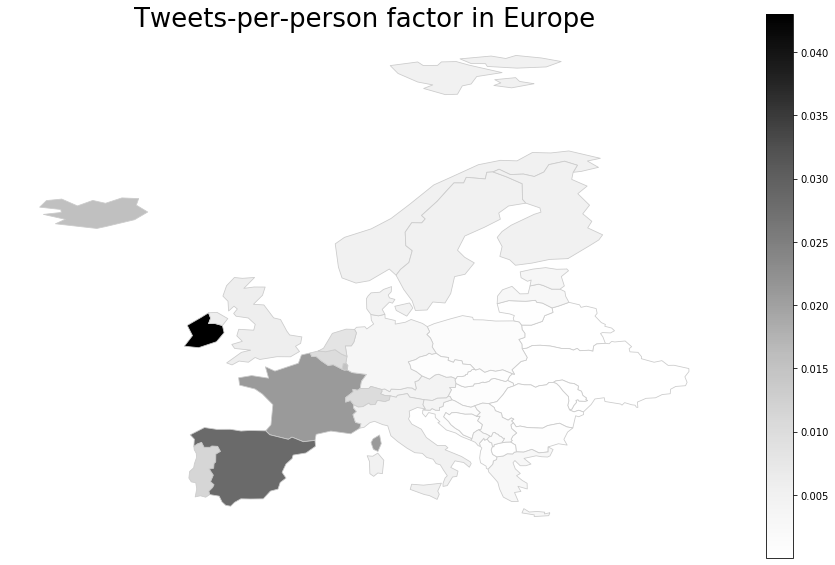

In [31]:
europe_map_with_tweets_per_person = europe_map_with_tweets_per_person.loc[europe_map_with_tweets_per_person['name'] != 'russian federation', :]
plot_map("tweets per person", europe_map_with_tweets_per_person, "Tweets-per-person factor in Europe")